이산 푸리에 변환(DFT)과 그 기본 속성과 함께, DFT를 평가하는 효율적인 알고리즘인 고속 푸리에 변환(FFT)을 소개한다.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import scipy
import librosa
import IPython.display as ipd

- 푸리에 변환을 금방 이해하기는 쉽지 않다. 이해를 돕기 위해 영상을 준비했다.

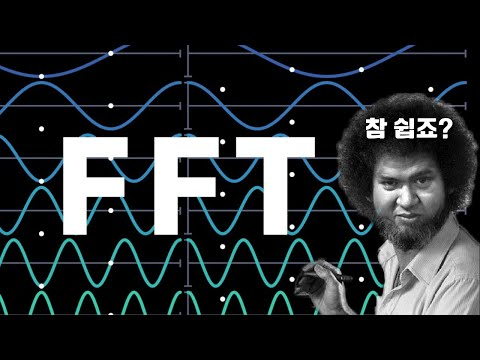

In [8]:
ipd.display(ipd.YouTubeVideo("eKSmEPAEr2U", width=16*40, height=9*40))

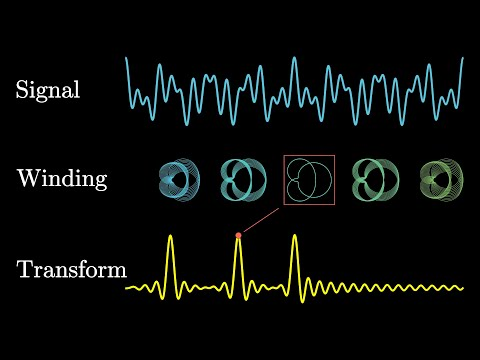

In [9]:
ipd.display(ipd.YouTubeVideo("spUNpyF58BY", width=16*40, height=9*40))

# 이산 푸리에 변환 (Discrete Fourier Transform, DFT)

## 내적 (Inner Product)

- 푸리에 변환(Fourier transform)을 이해하기 위한 중요한 개념으로 $N \in \mathbb{N}$에 대한 복소(complex) 벡터 공간 $\mathbb{C}^N$에 대한 **내적(inner product)** 이 있다.

- 두 개의 복소수 벡터 $x, y \in \mathbb{C}^N$가 주어지면, $x$와 $y$ 사이의 내적은 다음과 같이 정의된다.
$$\langle x | y \rangle := \sum_{n=0}^{N-1} x(n) \overline{y(n)}.$$

- 내적의 절대값은 $x$와 $y$ 사이의 유사성의 척도로 해석될 수 있다. 
    - $x$와 $y$가 동일한 방향을 가리키면(즉, $x$와 $y$가 유사함), 내적 $|\langle x | y \rangle|$이 크다. 
    - $x$와 $y$가 직교하면(즉, $x$와 $y$가 서로 다른 경우), 내적 $|\langle x | y \rangle|$는 0이다.

- 함수 `np.vdot`을 사용하여 내적을 계산할 때 첫 번째 인수에 대해 복소 켤레(complex conjugate)가 수행된다는 점에 유의하자. 
- 따라서, 위에서 정의된 $\langle x | y \rangle$를 계산하려면, `np.vdot(y, x)`를 사용해야 한다.

In [3]:
x = np.array([ 1.0, 1j, 1.0 + 1.0j ])
y = np.array([ 1.1, 1j, 0.9 + 1.1j ])
print('Vectors of high similarity:', np.abs(np.vdot(y, x)))

x = np.array([ 1.0,   1j, 1.0 + 1j ])
y = np.array([ 1.1, -1j, 0.1      ])
print('Vectors of low similarity:', np.abs(np.vdot(y, x)))

Vectors of high similarity: 4.104875150354758
Vectors of low similarity: 0.22360679774997913


## DFT의 정의

- $x\in \mathbb{C}^N$을 길이가 $N\in\mathbb{N}$인 벡터라고 하자. 음악 신호의 맥락에서 $x$는 샘플 $x(0), x(1), ..., x(N-1)$가 있는 이산(discrete) 신호로 해석될 수 있다. 

- **이산 푸리에 변환**(DFT)은 다음과 같이 정의된다.
$$ X(k) := \sum_{n=0}^{N-1} x(n) \exp(-2 \pi i k n / N) $$
for $k \in [0:N-1]$. 

- 벡터 $X\in\mathbb{C}^N$는 시간 영역(time-domain) 신호 $x$의 주파수 표현(frequency representation)으로 해석될 수 있다. 

- DFT의 기하학적 해석을 얻기 위해 벡터 $\mathbf{u}_k\in\mathbb{C}^N$를 다음과 같이 정의한다.
$$\mathbf{u}_k(n) :=  \exp(2 \pi i k n / N) = \cos(2 \pi k n / N) + i \sin(2 \pi k n / N)$$
for $k \in [0:N-1]$. 

- 이 벡터는 주파수 $k/N$의 지수 함수의 샘플링된 버전으로 볼 수 있다. 그러면 DFT는 신호 $x$ 및 샘플링된 지수 함수 $\mathbf{u}_k$의 내적으로 표현될 수 있다.
$$ X(k) := \sum_{n=0}^{N-1} x(n) \overline{\mathbf{u}_k} = \langle x | \mathbf{u}_k \rangle$$

- 절대값 $|X(k)|$는 신호 $x$와 $\mathbf{u}_k$ 사이의 유사도를 나타낸다.

- $x\in \mathbb{R}^N$이 실수 값 벡터(음악 신호 시나리오의 경우, 항상 해당)인 경우 다음을 얻는다.

$$ X(k) := \langle x |\mathrm{Re}(\mathbf{u}_k) \rangle - i\langle x | \mathrm{Im}(\mathbf{u}_k) \rangle $$

- 다음 그림은 두 개의 서로 다른 주파수 파라미터 $k$에 대한 함수 $\overline{\mathbf{u}_k}$와 비교한 신호 $x$의 예를 보여준다. 
    - $\overline{\mathbf{u}_k}$의 실수부와 허수부는 각각 <font color='red'> 빨간색</font> 및 <font color='blue'> 파란색</font>으로 표시된다.

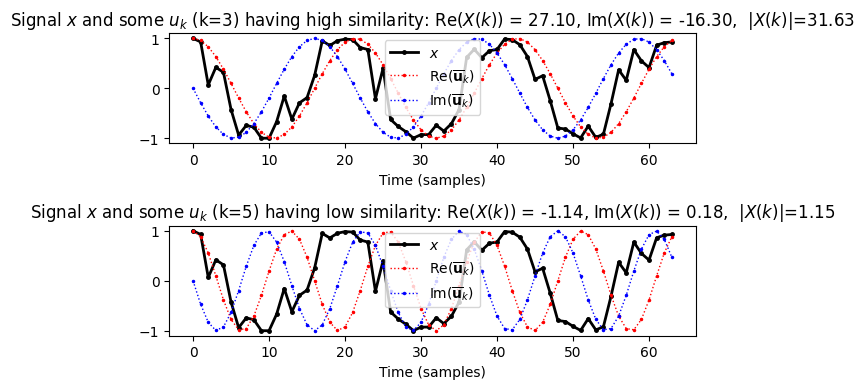

In [4]:
N = 64
n = np.arange(N)
k = 3
x = np.cos(2 * np.pi * (k * n / N) + (1.2*np.random.rand(N) - 0.0))

plt.figure(figsize=(6, 4))

plt.subplot(2, 1, 1)
plt.plot(n, x, 'k', marker='.', markersize='5', linewidth=2.0, label='$x$')
plt.xlabel('Time (samples)')
k = 3
u_k_real = np.cos(2 * np.pi * k * n / N)
u_k_imag = -np.sin(2 * np.pi * k * n / N)
u_k = u_k_real + u_k_imag*1j
sim_complex = np.vdot(u_k, x)
sim_abs = np.abs(sim_complex)
plt.title(r'Signal $x$ and some $u_k$ (k=3) having high similarity: Re($X(k)$) = %0.2f, Im($X(k)$) = %0.2f,  $|X(k)|$=%0.2f'%(sim_complex.real,sim_complex.imag,sim_abs))
plt.plot(n, u_k_real, 'r', marker='.', markersize='3', 
         linewidth=1.0, linestyle=':', label='$\mathrm{Re}(\overline{\mathbf{u}}_k)$');
plt.plot(n, u_k_imag, 'b', marker='.', markersize='3', 
         linewidth=1.0, linestyle=':', label='$\mathrm{Im}(\overline{\mathbf{u}}_k)$');
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(n, x, 'k', marker='.', markersize='5', linewidth=2.0, label='$x$')
plt.xlabel('Time (samples)')
k = 5
u_k_real = np.cos(2 * np.pi * k * n / N)
u_k_imag = -np.sin(2 * np.pi * k * n / N)
u_k = u_k_real + u_k_imag*1j
sim_complex = np.vdot(u_k, x)
sim_abs = np.abs(sim_complex)
plt.title(r'Signal $x$ and some $u_k$ (k=5) having low similarity: Re($X(k)$) = %0.2f, Im($X(k)$) = %0.2f,  $|X(k)|$=%0.2f'%(sim_complex.real,sim_complex.imag,sim_abs))
plt.plot(n, u_k_real, 'r', marker='.', markersize='3', 
         linewidth=1.0, linestyle=':', label='$\mathrm{Re}(\overline{\mathbf{u}}_k)$');
plt.plot(n, u_k_imag, 'b', marker='.', markersize='3', 
         linewidth=1.0, linestyle=':', label='$\mathrm{Im}(\overline{\mathbf{u}}_k)$');
plt.legend()

plt.tight_layout()

## DFT 행렬 (DFT Matrix)

- 선형 연산자 $\mathbb{C}^N \to \mathbb{C}^N$이면, DFT는 $N\times N$-행렬로 표현할 수 있다. 이는 다음과 같은 유명한 DFT 행렬 $\mathrm{DFT}_N \in \mathbb{C}^{N\times N}$ 행렬로 이어진다.
$$\mathrm{DFT}_N(n, k) = \mathrm{exp}(-2 \pi i k n / N)$$
for $n\in[0:N-1]$ and $k\in[0:N-1]$. 

- $\rho_N:=\exp(2 \pi i / N)$를 단위 N승근 (primitive Nth roots of unity)이라고 한다. 또한 단위 N승근을 다음과 같이 정의한다.
    - $\sigma_N:= \overline{\rho_N} = \mathrm{exp}(-2 \pi i / N)$

- 지수 함수의 속성으로부터 다음을 얻을 수 있다.
    - $\sigma_N^{kn} = \mathrm{exp}(-2 \pi i / N)^{kn} = \mathrm{exp}(-2 \pi i k n / N)$

- 이로부터 다음의 행렬을 얻는다.
$$
\mathrm{DFT}_N =
\begin{pmatrix}
    1 & 1 & 1 & \dots  & 1 \\
    1 & \sigma_N & \sigma_N^2 & \dots  & \sigma_N^{N-1} \\
    1 & \sigma_N^2 & \sigma_N^4 & \dots  & \sigma_N^{2(N-1)} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & \sigma_N^{N-1} & \sigma_N^{2(N-1)} & \dots  & \sigma_N^{(N-1)(N-1)} \\
\end{pmatrix}
$$

- 다음 그림에서 $\mathrm{DFT}_N$의 실수 및 허수 부분이 표시되며, 값은 적절한 색상으로 인코딩된다. $\mathrm{DFT}_N$의 $k^\mathrm{th}$ 행은 위에 정의된 벡터 $\mathbf{u}_k$에 해당한다.

In [5]:
def generate_matrix_dft(N, K):
    """Generates a DFT (discrete Fourier transfrom) matrix

    Args:
        N (int): Number of samples
        K (int): Number of frequency bins

    Returns:
        dft (np.ndarray): The DFT matrix
    """
    dft = np.zeros((K, N), dtype=np.complex128)
    for n in range(N):
        for k in range(K):
            dft[k, n] = np.exp(-2j * np.pi * k * n / N)
    return dft

def dft(x):
    """Compute the disrcete Fourier transfrom (DFT)

    Args:
        x (np.ndarray): Signal to be transformed

    Returns:
        X (np.ndarray): Fourier transform of x
    """
    x = x.astype(np.complex128)
    N = len(x)
    dft_mat = generate_matrix_dft(N, N)
    return np.dot(dft_mat, x)

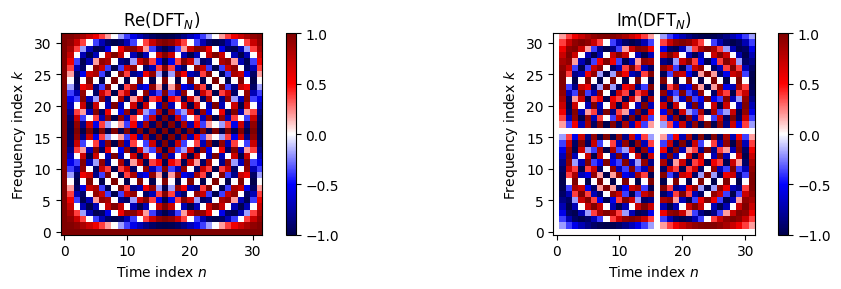

In [6]:
N = 32
dft_mat = generate_matrix_dft(N, N)

plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.title('$\mathrm{Re}(\mathrm{DFT}_N)$')
plt.imshow(np.real(dft_mat), origin='lower', cmap='seismic', aspect='equal')
plt.xlabel('Time index $n$')
plt.ylabel('Frequency index $k$')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('$\mathrm{Im}(\mathrm{DFT}_N)$')
plt.imshow(np.imag(dft_mat), origin='lower', cmap='seismic', aspect='equal')
plt.xlabel('Time index $n$')
plt.ylabel('Frequency index $k$')
plt.colorbar()
plt.tight_layout()

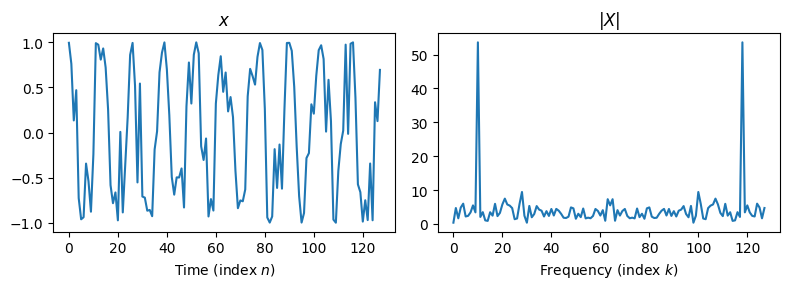

In [7]:
N = 128
n = np.arange(N)
k = 10
x = np.cos(2 * np.pi * (k * n / N) + 2 * (np.random.rand(N) - 0.5)) 
X = dft(x)

plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.title('$x$')
plt.plot(x)
plt.xlabel('Time (index $n$)')

plt.subplot(1, 2, 2)
plt.title('$|X|$')
plt.plot(np.abs(X))
plt.xlabel('Frequency (index $k$)')
plt.tight_layout()

# 고속 푸리에 변환 (Fast Fourier Transform, FFT)

- 다음으로 DFT를 계산하는 빠른 알고리즘인 고속 푸리에 변환(FFT)에 대해 설명한다. FFT 알고리즘은 원래 1805년 즈음에 Gauss에 의해 발견되었고 1965년에 Cooley와 Tukey에 의해 재발견되었다. 

- FFT 알고리즘은 짝수 크기 $N=2M$의 DFT를 적용하는 것이 $M$의 절반 크기인 두 개의 DFT를 적용하는 것으로 표현될 수 있다는 관찰을 기반으로 한다. DFT 행렬의 $\sigma_N^{kn} = \mathrm{exp}(-2 \pi i / N)^{kn}$ 항목 사이에 대수 관계가 있다는 사실을 이용한다.

$$\sigma_M = \sigma_N^2$$

- FFT 알고리즘에서 $x$의 짝수-인덱스와 홀수-인덱스 항목의 DFT를 계산한다.
\begin{align}
(A(0), \dots, A(N/2-1)) &= \mathrm{DFT}_{N/2} \cdot (x(0), x(2), x(4), \dots, x(N-2))\\
(B(0), \dots, B(N/2-1)) &= \mathrm{DFT}_{N/2} \cdot (x(1), x(3), x(5), \dots, x(N-1))
\end{align}

- $N/2$ 크기의 두 DFT로 부터 $N$ 크기의 전체 DFT를 다음과 같이 계산할 수 있다.
$$
C(k) = \sigma_N^k \cdot B(k)\\
X(k) = A(k) + C(k)\\
X(N/2 + k) = A(k) - C(k)
$$
for $k \in [0: N/2 - 1]$

- 숫자 $\sigma_N^k$는 "**twiddle factor**"라고도 한다. $N$이 2의 거듭제곱인 경우, 이 아이디어는 $\mathrm{DFT}_{1}$($N=1$의 경우)의 계산에 도달할 때까지 재귀적으로 적용될 수 있다.

In [8]:
def twiddle(N):
    """Generate the twiddle factors used in the computation of the fast Fourier transform (FFT)
    Args:
        N (int): Number of samples

    Returns:
        sigma (np.ndarray): The twiddle factors
    """
    k = np.arange(N // 2)
    sigma = np.exp(-2j * np.pi * k / N)
    return sigma


def fft(x):
    """Compute the fast Fourier transform (FFT)
    Args:
        x (np.ndarray): Signal to be transformed

    Returns:
        X (np.ndarray): Fourier transform of x
    """
    x = x.astype(np.complex128)
    N = len(x)
    log2N = np.log2(N)
    assert log2N == int(log2N), 'N must be a power of two!'
    X = np.zeros(N, dtype=np.complex128)

    if N == 1:
        return x
    else:
        this_range = np.arange(N)
        A = fft(x[this_range % 2 == 0])
        B = fft(x[this_range % 2 == 1])
        C = twiddle(N) * B
        X[:N//2] = A + C
        X[N//2:] = A - C
        return X

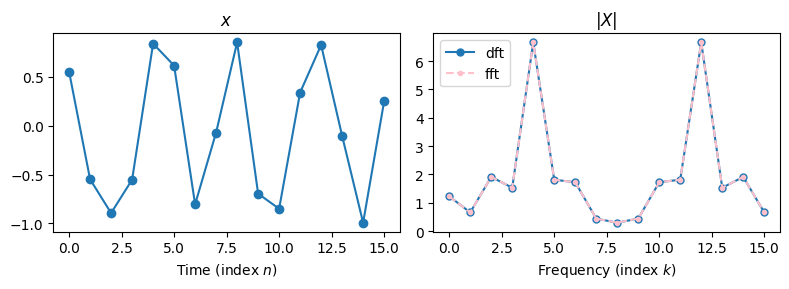

In [9]:
N = 16
n = np.arange(N)
k = 4
x = np.cos(2 * np.pi * (k * n / N) + 2 * (np.random.rand(N) - 0.5)) 
X_via_dft = dft(x)
X_via_fft = fft(x)


plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.title('$x$')
plt.plot(x, marker='.', markersize=12)
plt.xlabel('Time (index $n$)')

plt.subplot(1, 2, 2)
plt.title('$|X|$')
plt.plot(np.abs(X_via_dft), marker='.', markersize=10, label='dft')
plt.plot(np.abs(X_via_fft), linestyle='--', color='pink', marker='.', markersize=6, label='fft')
plt.xlabel('Frequency (index $k$)')
plt.legend()

plt.tight_layout()

## 계산 복잡성

- FFT는 전체 작업 수를 $N^2$(일반적인 행렬-벡터 곱 $\mathrm{DFT}_N \cdot x$를 계산할 때 필요함)에서 $N\log_2N$ 정도로 줄인다. 예를 들어 $N=2^{10}=1024$를 사용하면 원래의 접근 방식의 $N^2=1048576$ 작업 대신 FFT에 대략 $N\log_2N=10240$가 필요하다.

- Python 코드의 작은 비트의 시간을 측정하는 간단한 방법을 제공하는 `timeit` 모듈을 사용하여 실행 시간을 비교한다.

In [10]:
N = 512
n = np.arange(N)
x = np.sin(2 * np.pi * 5 * n / N )

print('Timing for DFT: ', end='')
%timeit dft(x)
print('Timing for FFT: ', end='')
%timeit fft(x)

Timing for DFT: 284 ms ± 6.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Timing for FFT: 9.31 ms ± 216 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


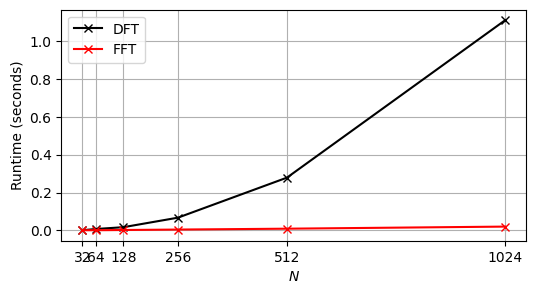

In [11]:
import timeit

Ns = [2 ** n for n in range(5, 11)]
times_dft = []
times_fft = []
execuctions = 5

for N in Ns:
    n = np.arange(N)
    x = np.sin(2 * np.pi * 5 * n / N )
    
    time_dft = timeit.timeit(lambda: dft(x), number=execuctions) / execuctions
    time_fft = timeit.timeit(lambda: fft(x), number=execuctions) / execuctions
    times_dft.append(time_dft)
    times_fft.append(time_fft)
    
plt.figure(figsize=(6, 3))
    
plt.plot(Ns, times_dft, '-xk', label='DFT')
plt.plot(Ns, times_fft, '-xr', label='FFT')
plt.xticks(Ns)
plt.legend()
plt.grid()
plt.xlabel('$N$')
plt.ylabel('Runtime (seconds)');

- FFT의 경우 계산이 훨씬 빠른 것을 볼 수 있다.

## FFT 예시

- librosa

In [12]:
x, sr = librosa.load("../audio/c_strum.wav")
print(x.shape)
print(sr)
ipd.Audio(x, rate=sr)

(102400,)
22050


In [13]:
X = scipy.fft.fft(x)
X_mag = np.absolute(X)
f = np.linspace(0, sr, len(X_mag)) # frequency variable

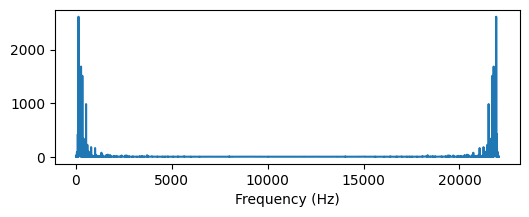

In [14]:
plt.figure(figsize=(6, 2))
plt.plot(f, X_mag) # magnitude spectrum
plt.xlabel('Frequency (Hz)')
plt.show()

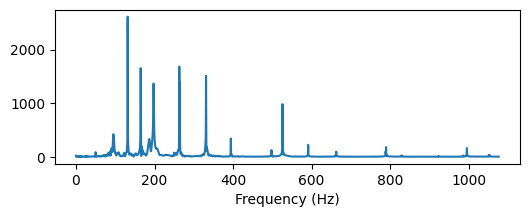

In [15]:
# zoom in
plt.figure(figsize=(6, 2))
plt.plot(f[:5000], X_mag[:5000])
plt.xlabel('Frequency (Hz)')
plt.show()

# DFT - 위상(Phase)

- DFT 계산 결과, 복소 푸리에 계수가 나온다. 이 각 계수는 크기(magnitude) 및 위상(phase) 구성 요소로 나타낼 수 있다.

## 푸리에 계수의 극좌표 표현 (Polar Representation of Fourier Coefficients)

- $x=(x(0), x(1), ..., x(N-1))$을 샘플 $x(n)\in\mathbb{R}$ for $n\in[0:N-1]$을 가지는 시그널이라고 하자. 복소 푸리에 계수 $c_k:=X(k)\in\mathbb{C}$ for $k\in[0:N-1]$는 DFT에 계산되어 다음과 같다.
$$ 
c_k :=X(k) = \sum_{n=0}^{N-1} x(n) \exp(-2 \pi i k n / N). 
$$

- $c_k = a_k + i b_k$를 실수부 $a_k\in\mathbb{R}$와 허수부 $b_k\in\mathbb{R}$로 구성된 복소수라고 할 때,
- 절대값은 $|c_k| := \sqrt{a_k^2 + b_k^2}$이고, 
- 각도(래디안 단위)는 $\gamma_k := \mathrm{angle}(c_k) := \mathrm{atan2}(b_k, a_k) \in [0,2\pi)$이다.

- 지수 함수를 쓰면, 다음의 극좌표 표현을 얻는다.
$$
    c_k = |c_k| \cdot \mathrm{exp}(i \gamma_k).
$$

## 최적화 Optimality 속성

- $\mathbf{cos}_{k,\varphi}:[0:N-1]\to\mathbb{R}$를 주파수 파라미터 $k$ 및 위상 $\varphi\in[0 ,1)$와 함께 샘플 정현파(sinusoid)라고 하면 다음과 같이 정의된다.
$$
    \mathbf{cos}_{k,\varphi}(n) = \sqrt{2}\mathrm{cos}\big( 2\pi (kn/N - \varphi) \big)
$$
for $n\in[0,N-1]$

- 직관적으로 말하자면, 길이 $N$의 이산 신호 $x$와 주파수 파라미터 $k$에 대한 푸리에 변환을 계산할 때 신호 $x$와 정현파 $\mathbf{cos}_{k,\varphi_k}$의 내적(일종의 상관 관계)을 계산한다. 

- $\varphi_k$ 위상은 $\varphi\in[0,1)$로 $x$와 모든 가능한 정현파 $\mathbf{cos}_{k,\varphi}$ 사이의 상관관계를 최대화한다는 속성을 가지고 있다.

$$
      \varphi_k = \mathrm{argmax}_{\varphi\in[0,1)} \langle x | \mathbf{cos}_{k,\varphi} \rangle.
$$

- 복소 푸리에 계수 $X(k)$는 기본적으로 복소수의 각도로 주어지는 이 최적 위상을 인코딩한다. 보다 정확하게 $\gamma_k$를 $X(k)$의 각도라고 하면, 최적 위상 $\varphi_k$가 다음과 같이 주어진다는 것을 알 수 있다.

$$
       \varphi_k := - \frac{\gamma_k}{2 \pi}.
$$

Sinusoid with phase from Fourier coefficient resulting in an optimal correlation.


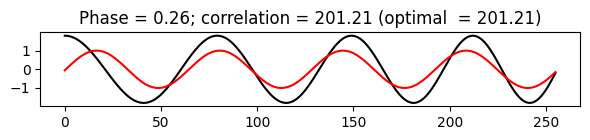

Sinusoid with an arbitrary phase resulting in a medium correlation.


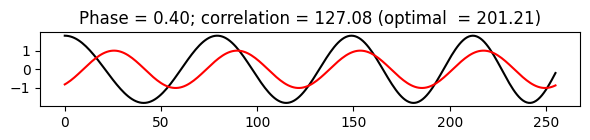

Sinusoid with a phase that yields a correlation close to zero.


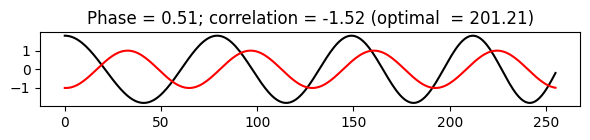

In [16]:
# Generate a chirp-like test signal (details not important)
N = 256
t_index = np.arange(N)
x = 1.8 * np.cos(2 * np.pi * (3 * (t_index * (1 + t_index / (4 * N))) / N))

k = 4
exponential = np.exp(-2 * np.pi * 1j * k * t_index / N)
X_k = np.sum(x * exponential)
phase_k = - np.angle(X_k) / (2 * np.pi)

def compute_plot_correlation(x, N, k, phase):
    sinusoid = np.cos(2 * np.pi * (k * t_index / N - phase)) 
    d_k = np.sum(x * sinusoid)
    plt.figure(figsize=(6,1.5))
    plt.plot(t_index, x, 'k')
    plt.plot(sinusoid, 'r')
    plt.title('Phase = %0.2f; correlation = %0.2f (optimal  = %0.2f)' % (phase, d_k, np.abs(X_k)))
    plt.tight_layout()
    plt.show()

print('Sinusoid with phase from Fourier coefficient resulting in an optimal correlation.')    
compute_plot_correlation(x, N, k, phase=phase_k)

print('Sinusoid with an arbitrary phase resulting in a medium correlation.')  
compute_plot_correlation(x, N, k, phase=0.4)

print('Sinusoid with a phase that yields a correlation close to zero.')  
compute_plot_correlation(x, N, k, phase=0.51)

---

출처: 

- https://www.audiolabs-erlangen.de/resources/MIR/FMP/C2/C2.html
---
